Liam Campbell - May 2017

# Support Vector Machine Analysis
* In this notebook I'll use wholesale product data to train different SVMs to predict which sales channel a given vendor is a part of (Hotel/Restaurant/Cafe or Retail)
* **Description of Data:** In a data set derived from N. Abreu, Analise do perfil do cliente Recheio e desenvolvimento de um sistema promocional, Mestrado em Marketing, ISCTE-IUL, Lisbon, 2011., the data consists of annual spending on different categories of products by each retailer, along with corresponding data on the sales channel (Hotel/Restaurant/Cafe = 1 vs. Retail = 2) and the region (Lisbon = 1, Oporto = 2, or Other = 3) of the retailer.

In [70]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sb

## Load Data

In [71]:
# Load data into dataframe
url = 'http://ieor.berkeley.edu/~ieor165/homeworks/wholesale-customers.csv'
df = pd.read_csv(url, sep=",")

# Store data locally in case url dies
df.to_csv('wholesale-customers.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## Data Preprocessing

In [72]:
# Use one-hot encoding to convert 'Region' column's string data to numeric form
df = pd.get_dummies(df, columns=['Region'])

# Convert 'Channel' column to binary for (1 --> 0 and 2 --> 1)
df['Channel'] = df['Channel'].apply(lambda x: 0 if x == 1 else 1)

# Check distribution of outcome data
df.Channel.value_counts()

0    298
1    142
Name: Channel, dtype: int64

In [73]:
# Shuffle the order of data points (by row)
df = df.reindex(np.random.permutation(df.index))

# Separate predictors and outcomes
x = df.drop(['Channel'], axis=1)
y = df.Channel

# Normalize predictor data
vals = x.values
norm_scaler = preprocessing.MinMaxScaler()
norm_vals = norm_scaler.fit_transform(vals)
x = pd.DataFrame(norm_vals)
x = x.rename(index=str, columns={0: 'Fresh', 1: 'Milk', 2: 'Grocery',3: 'Frozen', 4: 'Detergents_Paper',
                                 5: 'Delicassen', 6: 'Lisbon', 7: 'Oporto', 8: 'Other'})
#[u'Fresh', u'Milk', u'Grocery', u'Frozen', u'Detergents_Paper', u'Delicassen', u'Lisbon', u'Oporto', u'Other'])

# Check size of data set
df.shape

(440, 10)

In [74]:
# Split data into training and testing sets
x_train = x[:340]
x_test = x[340:]
y_train = y[:340]
y_test = y[340:]

# Create a scaler for standardization of data and standardize predictor data
# ONLY FOR USE IF NECESSARY, WILL NOT USE TO TRAIN AND TEST
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)
x_train.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Lisbon,Oporto,Other
0,0.085227,0.029438,0.017903,0.018868,0.005364,0.009262,0.0,0.0,1.0
1,0.029987,0.072818,0.139808,0.071905,0.146335,0.036316,0.0,0.0,1.0
2,0.001667,0.009150,0.021654,0.003616,0.004434,0.002587,0.0,0.0,1.0
3,0.474391,0.066773,0.079039,0.049093,0.023614,0.017000,1.0,0.0,0.0
4,0.062435,0.010539,0.032400,0.006656,0.014869,0.010972,0.0,0.0,1.0


# Linear SVM

In [75]:
from sklearn import svm

# Build linear SVC
svc_linear = svm.SVC(kernel='linear')
params_linear = np.logspace(-6, 6, 20)

In [76]:
# Perform cross-validation and find optimal C value
scores_linear = []
for i in params_linear:
    svc_linear.C = i
    scores = cross_val_score(svc_linear, x, y, cv=5)
    scores_linear.append(1 - np.mean(scores))

index_linear = scores_linear.index(min(scores_linear))
C_linear = params_linear[index_linear]

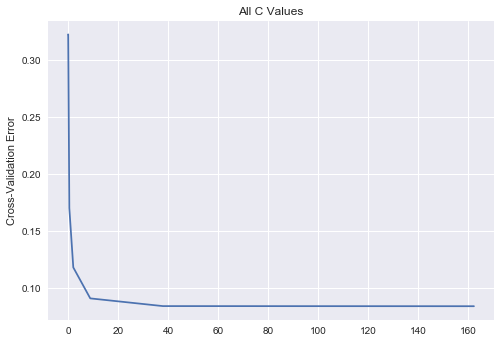

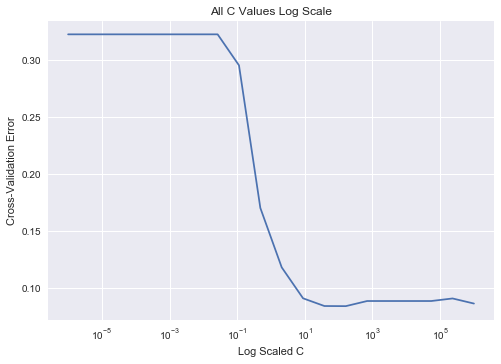

In [77]:
# Plot cross-validation error
plt.plot(params_linear[:14], scores_linear[:14])
plt.xlabel('')
plt.ylabel('Cross-Validation Error')
plt.title('All C Values')
plt.show()

plt.plot(params_linear, scores_linear)
plt.xlabel('Log Scaled C')
plt.ylabel('Cross-Validation Error')
plt.title('All C Values Log Scale')
plt.xscale('log')
plt.show()

In [78]:
# Fit linear SVM
svc_linear = svm.SVC(C=C_linear, kernel='linear')
svc_linear.fit(x_train, y_train)

SVC(C=162.37767391887175, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [79]:
# Extract model data
svc_linear_coef = svc_linear.coef_.tolist()
features = x.columns.tolist()
svc_linear_params = pd.DataFrame()
svc_linear_params['Features'] = pd.Series(features)
svc_linear_params['Coefficients'] = pd.Series(svc_linear_coef[0])

m = svc_linear.predict(x_test)
print 'Accuracy: ', metrics.accuracy_score(y_test, m)

print ''

print 'Hyperparamater (C) = ', C_linear
print 'Min CV Error: ', min(scores_linear)
print 'Intercept: ', svc_linear.intercept_
print 'Coefficients: '
print svc_linear_params
m = svc_linear.predict(x_test)
print metrics.accuracy_score(y_test, m)

Accuracy:  0.95

Hyperparamater (C) =  162.377673919
Min CV Error:  0.0841252509598
Intercept:  [-2.06624396]
Coefficients: 
           Features  Coefficients
0             Fresh     -0.182482
1              Milk      4.797425
2           Grocery      4.181490
3            Frozen     -2.014606
4  Detergents_Paper     20.456078
5        Delicassen     -5.774796
6            Lisbon     -0.630617
7            Oporto      0.425345
8             Other      0.205272
0.95


# Polynomial SVM

In [80]:
# Build polynomial svm
svc_poly = svm.SVC(kernel='poly')
params_poly = np.array(range(0,10))

In [81]:
# Perform cross-validation over polynomial degrees with constant C value
scores_poly = []
for i in params_poly:
    svc_poly.degree = i
    svc_poly.C = C_linear
    scores = cross_val_score(svc_poly, x, y, cv=5)
    scores_poly.append(1 - np.mean(scores))

index_poly = scores_poly.index(min(scores_poly))
optimal_poly = params_poly[index_poly]

# Perform cross-validation over C values with constant optimal polynomial degree
scores_C = []
for i in params_linear:
    svc_poly.degree = 1
    svc_poly.C = i
    scores = cross_val_score(svc_poly, x, y, cv=5)
    scores_C.append(1 - np.mean(scores))

index_C = scores_C.index(min(scores_C))
C_poly = params_linear[index_C]

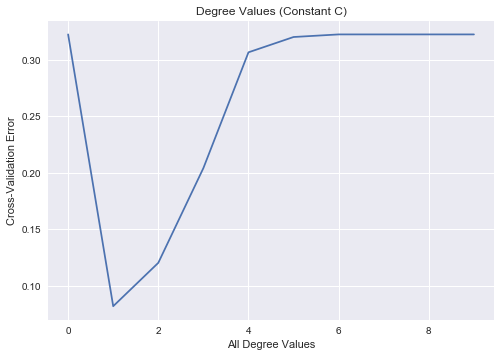

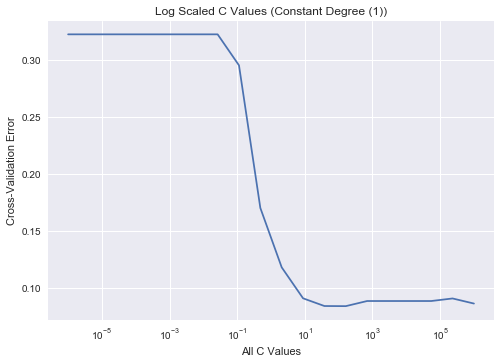

In [82]:
# Plot cross-validation error
plt.plot(params_poly, scores_poly[:10])
plt.xlabel('All Degree Values')
plt.ylabel('Cross-Validation Error')
plt.title('Degree Values (Constant C)')
plt.show()

plt.plot(params_linear, scores_linear)
plt.xlabel('All C Values')
plt.ylabel('Cross-Validation Error')
plt.title('Log Scaled C Values (Constant Degree (1))')
plt.xscale('log')
plt.show()

In [83]:
# Fit polynomial SVM
svc_poly = svm.SVC(C=C_poly, kernel='poly')
svc_poly.fit(x_train, y_train)

SVC(C=162.37767391887175, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [84]:
# Extract model data
m = svc_poly.predict(x_test)
print 'Accuracy: ', metrics.accuracy_score(y_test, m)

print ''

print 'Hyperparamater (Degree) = ', optimal_poly
print 'Hyperparamater (C) = ', C_poly
print 'Min CV Error: ', min(scores_poly)
print 'Coefficients are non-recoverable in SVM with non-linear kernel.'

Accuracy:  0.83

Hyperparamater (Degree) =  1
Hyperparamater (C) =  162.377673919
Min CV Error:  0.0819297195121
Coefficients are non-recoverable in SVM with non-linear kernel.


# Gaussian SVM

In [85]:
# Build Gaussian svm
svc_gamma = svm.SVC(kernel='rbf')
params_gamma = np.arange(.2, 5, .2).tolist()

In [86]:
# Perform cross-validation with constant C and find optimal gamma value
scores_gamma = []
for i in params_gamma:
    svc_gamma.C = C_linear
    svc_gamma.gamma = i
    scores = cross_val_score(svc_gamma, x, y, cv=5)
    scores_gamma.append(1 - np.mean(scores))

index_gamma = scores_gamma.index(min(scores_gamma))
optimal_gamma = params_gamma[index_gamma]

# Perform cross-validation over C values with constant optimal gamma value
scores_C = []
for i in params_linear:
    svc_gamma.gamma = optimal_gamma
    svc_gamma.C = i
    scores = cross_val_score(svc_gamma, x, y, cv=5)
    scores_C.append(1 - np.mean(scores))

index_C = scores_C.index(min(scores_C))
C_gamma = params_linear[index_C]

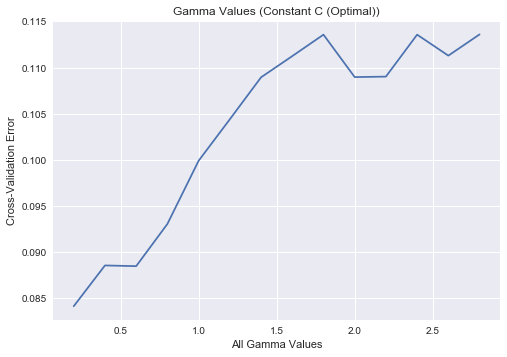

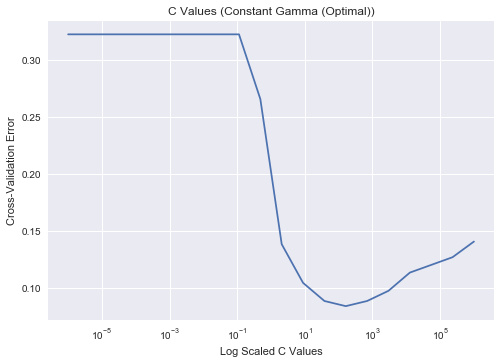

In [92]:
# Plot cross-validation error
plt.plot(params_gamma[:14], scores_gamma[:14])
plt.xlabel('All Gamma Values')
plt.ylabel('Cross-Validation Error')
plt.title('Gamma Values (Constant C (Optimal))')
plt.show()

plt.plot(params_linear, scores_C)
plt.xlabel('Log Scaled C Values')
plt.ylabel('Cross-Validation Error')
plt.title('C Values (Constant Gamma (Optimal))')
plt.xscale('log')
plt.show()

In [88]:
# Fit gaussian SVM
svc_gamma = svm.SVC(C=C_gamma, kernel='rbf')
svc_gamma.fit(x_train, y_train)

SVC(C=162.37767391887175, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [89]:
# Exctract model data
m = svc_gamma.predict(x_test)
print 'Accuracy: ', metrics.accuracy_score(y_test, m)

print ''

print 'Hyperparamater (Gamma) = ', optimal_gamma
print 'Hyperparamater (C) = ', C_gamma
print 'Min CV Error: ', min(scores_gamma)
print 'Coefficients are non-recoverable in SVM with non-linear kernel.'

Accuracy:  0.96

Hyperparamater (Gamma) =  0.2
Hyperparamater (C) =  162.377673919
Min CV Error:  0.0841513742618
Coefficients are non-recoverable in SVM with non-linear kernel.


## Conclution
* Depending on the random ordering of the data before it is split into training and testing sets, each model's accuracy varies a bit with this is a smaller data set. However, since the data appears to be distributed in not too complex of a manner, the scoring between the models is fairly similar when multiple trials are averaged out. With this, the Linear SVM stands out as the reasonable choice. Notice that through cross-validation the Polynomial SVM was actually tuned to essentially be linear since its optimal degree was determined to be 1.